In [1]:
# GPU details
!nvidia-smi

Thu Jan  9 13:01:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# CPU details
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

In [0]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [0]:
import os # for basic operations like folder creation, directory validation etc
import glob # finds file according to wildcard given
import shutil # for moving files
import matplotlib.pyplot as plt # for plotting graphs and viewing images

In [8]:
from keras.models import Model
from keras import backend as K
from keras.layers import Input
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint

img_width, img_height = 96, 96
train_data_dir = '/content/drive/My Drive/inceptionv3 files/fvc2006SETA'
validation_data_dir = '/content/drive/My Drive/inceptionv3 files/fvc2006SETA'
nb_train_samples = 1008
nb_validation_samples = 672
batch_size = 32
epochs = 100

if K.image_data_format() == 'channels_last':
    input_tensor = Input(shape=(img_width, img_height, 3))
else:
    input_tensor = Input(shape=(3, img_width, img_height))


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    validation_split=0.40,
)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')

# imports the inceptionv3 pretained model
inception_model = InceptionV3(input_tensor=input_tensor, weights=None, include_top=False)

x = inception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
predictions = Dense(140, activation='softmax')(x)

model = Model(inputs=inception_model.input, outputs=predictions)

# functions to calculate f1score
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy', f1score, recall_m, precision_m])
# model.summary()

filepath_accuracy = 'accuracy_weights.{epoch:02d}-{val_acc:.2f}.hdf5'
filepath_f1score = 'f1score_weights.{epoch:02d}-{val_f1score:.2f}.hdf5'

csv_logger = CSVLogger('training.log')

accuracy_checkpoint = ModelCheckpoint(filepath_accuracy, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)
f1score_checkpoint = ModelCheckpoint(filepath_f1score, monitor='val_f1score', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        shuffle=True,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        callbacks=[csv_logger, accuracy_checkpoint, f1score_checkpoint]
        )

Found 1120 images belonging to 140 classes.
Found 560 images belonging to 140 classes.
Epoch 1/100
31/31 [==============================] - 163s 5s/step - loss: 5.5752 - acc: 0.0202 - f1score: 0.0095 - recall_m: 0.0050 - precision_m: 0.0806 - val_loss: 11.6067 - val_acc: 0.0091 - val_f1score: 0.0074 - val_recall_m: 0.0061 - val_precision_m: 0.0093
Epoch 2/100
31/31 [==============================] - 7s 211ms/step - loss: 4.8787 - acc: 0.0212 - f1score: 0.0097 - recall_m: 0.0050 - precision_m: 0.1290 - val_loss: 5.3723 - val_acc: 0.0107 - val_f1score: 0.0168 - val_recall_m: 0.0091 - val_precision_m: 0.1341
Epoch 3/100
31/31 [==============================] - 7s 233ms/step - loss: 4.5193 - acc: 0.0423 - f1score: 0.0097 - recall_m: 0.0050 - precision_m: 0.1452 - val_loss: 5.1356 - val_acc: 0.0473 - val_f1score: 0.0208 - val_recall_m: 0.0122 - val_precision_m: 0.0852
Epoch 4/100
31/31 [==============================] - 7s 225ms/step - loss: 4.1584 - acc: 0.0857 - f1score: 0.0000e+00 - reca

In [0]:
model.save('inceptionv3.h5')

dict_keys(['val_loss', 'val_acc', 'val_f1score', 'val_recall_m', 'val_precision_m', 'loss', 'acc', 'f1score', 'recall_m', 'precision_m'])


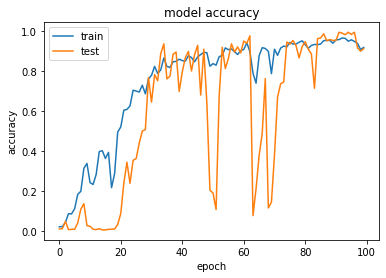

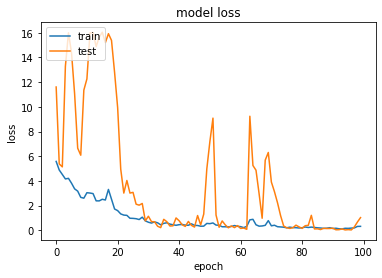

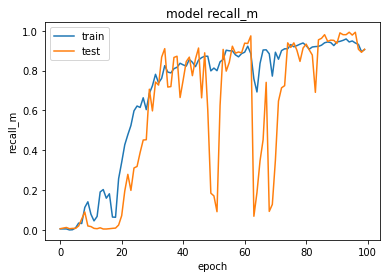

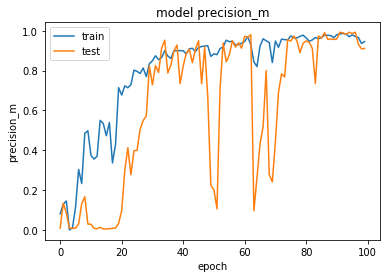

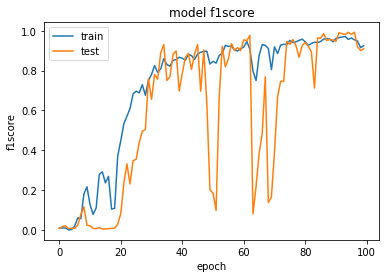

In [10]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for recall
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('model recall_m')
plt.ylabel('recall_m')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for precision
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('model precision_m')
plt.ylabel('precision_m')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for f1score
plt.plot(history.history['f1score'])
plt.plot(history.history['val_f1score'])
plt.title('model f1score')
plt.ylabel('f1score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()